# <center><h1 style = "color:navy;">Classify animal type by KNN</h1></center>

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn.preprocessing import StandardScaler     #for scaling the features before modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from sklearn.decomposition import PCA

### <h2 style="color:purple">1. Exploratory Data Analysis</h2>

In [2]:
zoo = pd.read_csv("zoo.csv")
zoo.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [3]:
zoo.shape

(101, 18)

In [4]:
zoo.nunique()

animal name    100
hair             2
feathers         2
eggs             2
milk             2
airborne         2
aquatic          2
predator         2
toothed          2
backbone         2
breathes         2
venomous         2
fins             2
legs             6
tail             2
domestic         2
catsize          2
type             7
dtype: int64

In [5]:
zoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  type         101 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


**We have different characteristics of 100 animals in our dataset along with the animal name. All categorical columns have already been encoded and most of them have binary/boolean values.**

There is one animal in our dataset that have been repeated twice as unique animal anime is 100 but there 101 values in our dataset.


In [6]:

zoo[zoo['animal name'].duplicated()]

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
26,frog,0,0,1,0,0,1,1,1,1,1,1,0,4,0,0,0,5


In [7]:
zoo[zoo['animal name'] =='frog']

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
25,frog,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0,5
26,frog,0,0,1,0,0,1,1,1,1,1,1,0,4,0,0,0,5


**We can see that one frog is venomous and another one is non venomous. We will name one of the differently so that we can keep the index of the dataframe as animal name.**

In [8]:
zoo.loc[(zoo['animal name'] == 'frog' ) & (zoo['venomous'] == 1),'animal name'] = 'Ven. frog'

In [9]:
zoo['animal name'].nunique()

101

In [10]:
zoo.set_index('animal name', inplace=True)

In [11]:
# Check for duplicate columns
duplicate_columns = zoo.columns[zoo.T.duplicated()].tolist()
if duplicate_columns:
    print(f"Duplicate columns found: {duplicate_columns}")
else:
    print("No duplicate columns found.")


No duplicate columns found.


#### <h3 style="color:midnightblue">Check for nulls</h3>

In [12]:
zoo.isna().sum()

hair        0
feathers    0
eggs        0
milk        0
airborne    0
aquatic     0
predator    0
toothed     0
backbone    0
breathes    0
venomous    0
fins        0
legs        0
tail        0
domestic    0
catsize     0
type        0
dtype: int64

#### <h3 style="color:midnightblue">Distribution of Animal Types</h3>

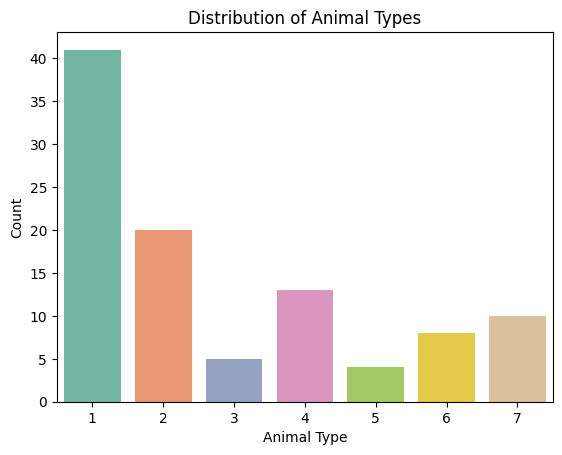

In [13]:
sns.countplot(data=zoo, x='type', palette='Set2')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.title('Distribution of Animal Types')
plt.show()


- We do have some minority classes in our dataset, we might have to handle them using oversampling later. 
- We have around 40 animals that is from class 1.

#### <h3 style="color:midnightblue">Heatmap based of Cramer's V</h3>

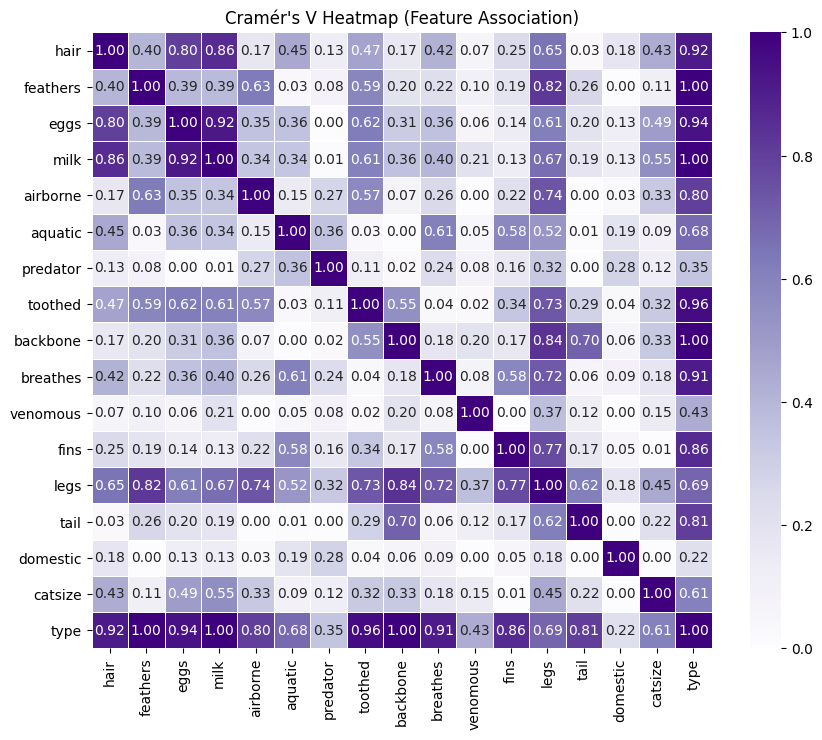

In [14]:

import scipy.stats as stats


# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

categorical_cols = zoo.select_dtypes(include=[ 'int']).columns  # Select categorical features

# Compute Cramér's V for each feature combination
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))), 
                                index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Self-correlation is always 1
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(zoo[col1], zoo[col2])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap="Purples", fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Heatmap (Feature Association)")
plt.show()



We can see there are many features that have perfect association with target feature(Type). We can analyze further and check the relationship between features to reduce the number of features while training

Features that have perfect association with target variable:
1. feathers
2. Milk
3.  backbone

Almost perfect associarion features:
1. hair
2. eggs
3. toothed
4. breathes

<Figure size 2000x500 with 0 Axes>

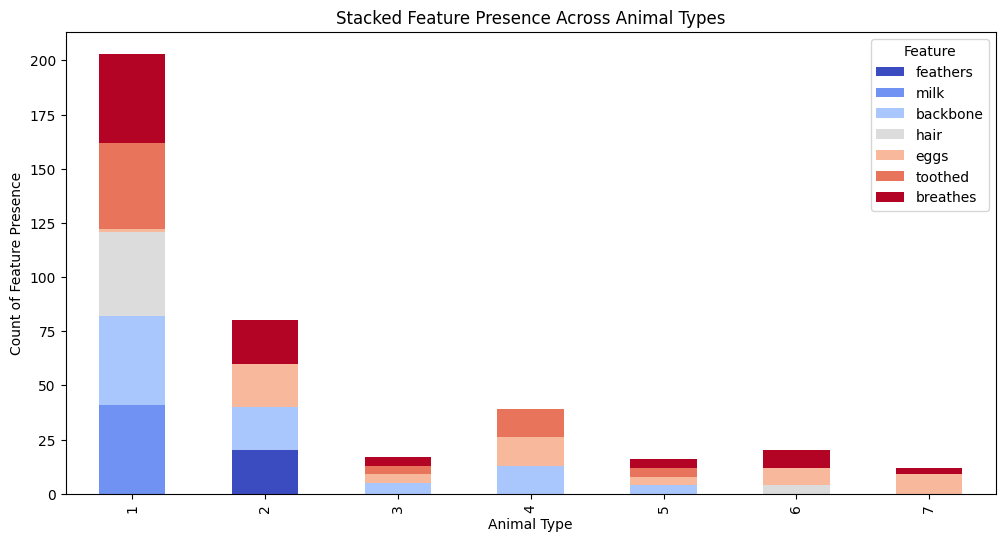

In [15]:
plt.figure(figsize=(20, 5))
feature_cols = ['feathers', 'milk', 'backbone', 'hair', 'eggs', 'toothed', 'breathes']
zoo.groupby("type")[feature_cols].sum().plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12, 6))
plt.title("Stacked Feature Presence Across Animal Types")
plt.ylabel("Count of Feature Presence")
plt.xlabel("Animal Type")
plt.legend(title="Feature")
plt.show()



Key Observations:
- Animal Type 1 has the highest total feature presence. This type has a significant amount of breathes, toothed, and backbone features. Also includes milk and hair, suggesting this type could represent mammals.
- Animal Type 2 has a moderate presence of features.It has feathers, which likely indicates birds.
- Animal Type 3, 5, 6, and 7 have fewer features overall. 
- Type 3 has fewer backbone-related features.
- Types 5, 6, and 7 may represent simpler organisms like fish, amphibians, or invertebrates.
- Egg-laying animals (orange bars) are spread across multiple types, likely including birds, reptiles, and fish.

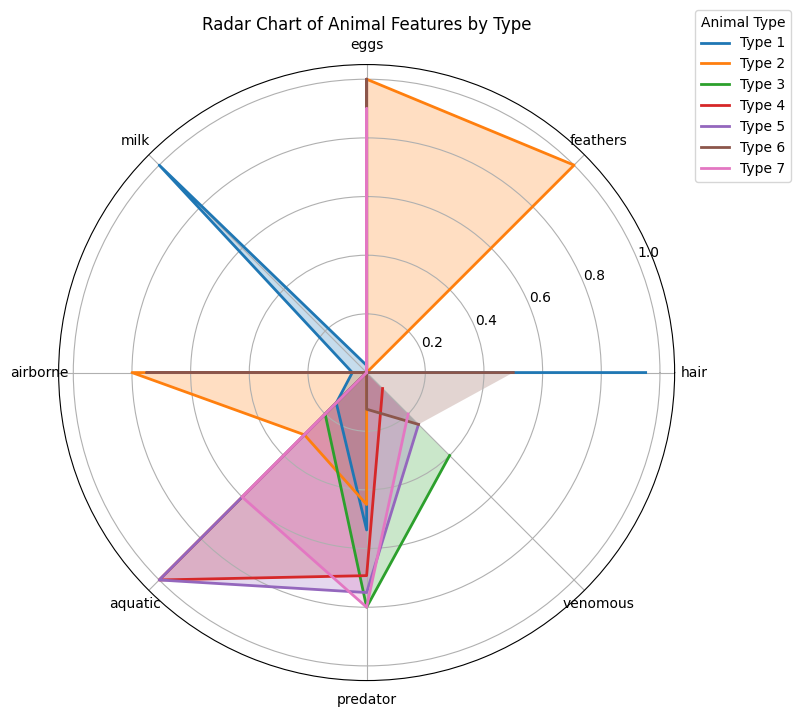

In [16]:
import numpy as np
import matplotlib.pyplot as plt

categories = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'venomous']
values = zoo.groupby('type')[categories].mean().values

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in enumerate(values):
    ax.plot(angles, row, label=f"Type {i+1}", linewidth=2)
    ax.fill(angles, row, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(categories)
plt.legend(title="Animal Type", bbox_to_anchor=(1.2, 1.1))
plt.title("Radar Chart of Animal Features by Type")
plt.show()



- Mammals (Type 1) have hair & milk but not eggs.
- Birds (Type 2) have feathers, eggs, and airborne ability.
-Reptiles & Amphibians (Type 3, 5, 6, 7) show venomous and predator traits.
- Aquatic animals (Type 4, 6, 7) dominate aquatic attributes.
- Predators exist across multiple types, but venomous ones are more restricted.

**Let's check if predators tend to have more or fewer legs than non-predators**

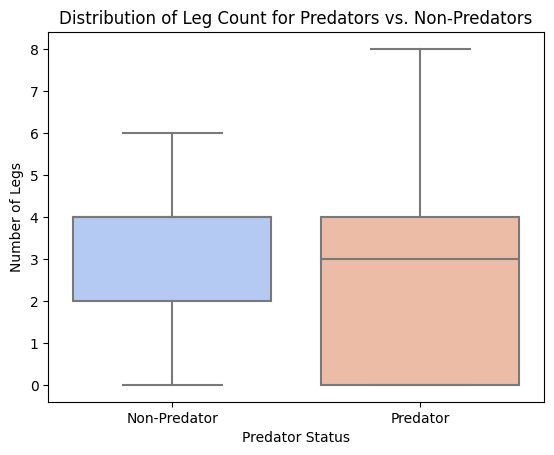

In [17]:
sns.boxplot(data=zoo, x='predator', y='legs', palette='coolwarm')
plt.xlabel('Predator Status')
plt.ylabel('Number of Legs')
plt.title('Distribution of Leg Count for Predators vs. Non-Predators')
plt.xticks([0, 1], ['Non-Predator', 'Predator'])
plt.show()


- Predators have more variability in leg count compared to non-predators.
- Some predators have 0 legs.
- Non-predators tend to cluster around 4 legs.

<Figure size 2000x500 with 0 Axes>

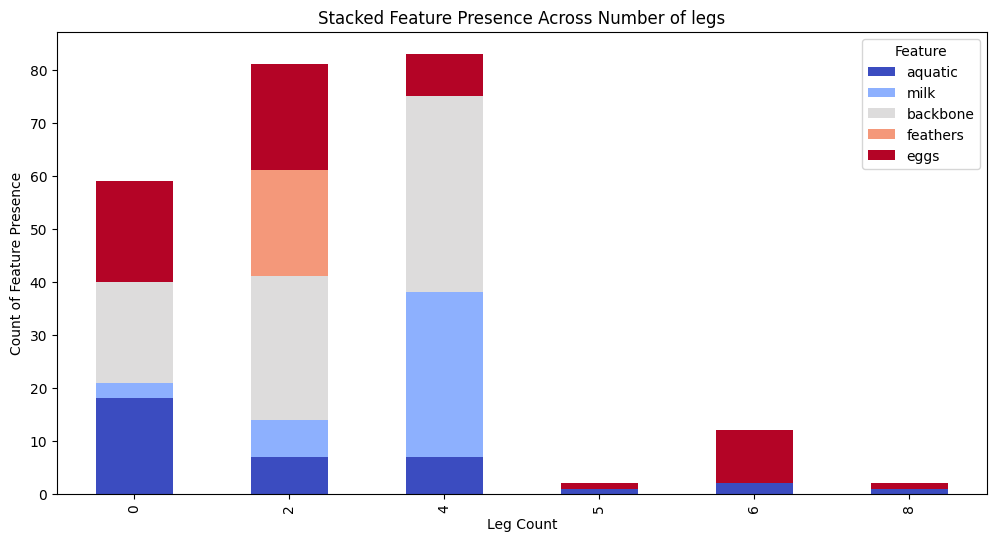

In [18]:
plt.figure(figsize=(20, 5))
feature_cols = ['aquatic', 'milk', 'backbone', 'feathers', 'eggs']
zoo.groupby("legs")[feature_cols].sum().plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12, 6))
plt.title("Stacked Feature Presence Across Number of legs")
plt.ylabel("Count of Feature Presence")
plt.xlabel("Leg Count")
plt.legend(title="Feature")
plt.show()


- Animals having 5 or more legs doesn't have backbone, feathers or milk
- Animals with 5, 6 or 8 legs are mostly egg-laying and aquatic.
- Milk presence is only in no legged, 2-legged and 4-legged animals, reinforcing that mammals dominate these categories.
- Animals with 4 legs (e.g., mammals, reptiles) show a significant presence of milk and backbone, indicating many are mammals.
- Animals with 2 legs have a strong presence of feathers, indicating many are birds.

#### <h3 style="color:midnightblue">Train test split</h3>

In [19]:
X = zoo.iloc[:,:16]
y = zoo.iloc[:,16]

In [20]:
# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check original class distribution
print("Original class distribution:", Counter(y_train))

# Apply SMOTE with k_neighbors=2
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTE class distribution:", Counter(y_train_smote))


Original class distribution: Counter({1: 33, 2: 16, 4: 10, 7: 8, 6: 6, 3: 4, 5: 3})
After SMOTE class distribution: Counter({7: 33, 3: 33, 2: 33, 4: 33, 1: 33, 6: 33, 5: 33})


#### <h3 style="color:midnightblue">Hyperparameter Tuning: Find Best K using GridSearchCV</h3>

In [22]:
# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],   # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting strategy
}

#as we are using metric as hamming, we won't have to use the hyperparameter (p)Power parameter for Minkowski distance



In [23]:
knn = KNeighborsClassifier(metric='hamming')  # Hamming Distance for Categorical Data
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(metric='hamming'),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [24]:
best_k = grid_search.best_params_['n_neighbors']
print(f"Best value for K: {best_k}")

Best value for K: 3


#### <h3 style="color:midnightblue">Train KNN with Best K</h3>

In [25]:
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric='hamming')
knn_best.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(metric='hamming', n_neighbors=3)

#### <h3 style="color:midnightblue">Evaluate using test data</h3>

In [26]:
y_pred = knn_best.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



We will also evaluate the model against the entire dataset, because we have low testing values

In [27]:
y_pred = knn_best.predict(X)
print("\nClassification Report:")
print(classification_report(y, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        20
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         8
           7       1.00      0.90      0.95        10

    accuracy                           0.99       101
   macro avg       0.98      0.99      0.98       101
weighted avg       0.99      0.99      0.99       101



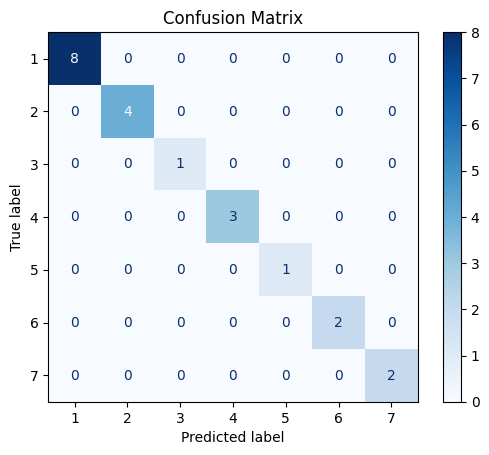

In [28]:
ConfusionMatrixDisplay.from_estimator(knn_best, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### <h3 style="color:midnightblue">Reduce the features</h3>

- We will create a pipeline of the above code so that we can reuse it for every feature combination we will be selecting.
- We will use the mutual information scores and random forest's feature importance scores to select the best k features

In [29]:

def knn_smote_pipeline(X, y, test_size=0.2, random_state=42, k_neighbors_smote=2, cv_folds=5):
    """
    Performs stratified train-test split, applies SMOTE, tunes KNN hyperparameters,
    trains the best model, and prints evaluation metrics.
    
    Parameters:
    - X: Feature matrix
    - y: Target variable
    - test_size: Proportion of test data (default 0.2)
    - random_state: Random seed for reproducibility (default 42)
    - k_neighbors_smote: Number of neighbors for SMOTE (default 2)
    - cv_folds: Number of cross-validation folds for GridSearchCV (default 5)
    """
    # Perform stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Apply SMOTE for balancing
    smote = SMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=k_neighbors_smote)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Define hyperparameter grid for KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],   # Number of neighbors
        'weights': ['uniform', 'distance'],  # Weighting strategy
    }
    
    # Initialize KNN with Hamming Distance for categorical data
    knn = KNeighborsClassifier(metric='hamming')
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(knn, param_grid, cv=cv_folds, scoring='accuracy')
    grid_search.fit(X_train_smote, y_train_smote)
    
    # Get best hyperparameter
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Best value for K: {best_k}")
    
    # Train the best model
    knn_best = KNeighborsClassifier(n_neighbors=best_k, metric='hamming')
    knn_best.fit(X_train_smote, y_train_smote)
    
    # Predict on test data
    y_pred = knn_best.predict(X_test)
    
    # Print classification report
    print("\nClassification Report test:")
    print(classification_report(y_test, y_pred))
    
      # Predict on test data
    y_full_pred = knn_best.predict(X)
    
    # Print classification report
    print("\nClassification Report whole dataset:")
    print(classification_report(y, y_full_pred))
    
    return knn_best


#### <h4 style="color:navy">Reduced to 12 features</h4>

In [30]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Mutual Information for feature selection
mi_selector = SelectKBest(score_func=mutual_info_classif, k=12)  # Select top 12 features
X_mi_selected = mi_selector.fit_transform(X, y)

print("Mutual Information selected top 12 features:", X.columns[mi_selector.get_support()])

Mutual Information selected top 12 features: Index(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'toothed',
       'backbone', 'breathes', 'fins', 'legs', 'tail'],
      dtype='object')


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# 3. Recursive Feature Elimination (RFE) with RandomForest
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=12)  # Selects top 12 features
X_rfe_selected = rfe.fit_transform(X, y)
print("RFE selected top 12 features:", X.columns[rfe.get_support()])

RFE selected top 12 features: Index(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'toothed',
       'backbone', 'breathes', 'fins', 'legs', 'tail'],
      dtype='object')


Both the methods give the same features:<br>
We will train KNN model based on the following features now:
1. hair
2. feathers
3. eggs
4. milk
5. airborne
6. aquatic
7. toothed
8. backbone
9. breathes
10. fins
11. legs
12. tail
    

In [32]:
reduced_X = X[X.columns[rfe.get_support()]]

In [33]:
model_12 = knn_smote_pipeline(reduced_X, y)

Best value for K: 3

Classification Report test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21


Classification Report whole dataset:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00  

#### <h4 style="color:navy">Reduced to 8 features</h4>

In [34]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Mutual Information for feature selection
mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 8 features
X_mi_selected = mi_selector.fit_transform(X, y)

print("Mutual Information selected top 8 features:", X.columns[mi_selector.get_support()])

Mutual Information selected top 8 features: Index(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'toothed', 'backbone',
       'breathes', 'legs', 'tail'],
      dtype='object')


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# 3. Recursive Feature Elimination (RFE) with RandomForest
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10)  # Selects top 8 features
X_rfe_selected = rfe.fit_transform(X, y)
print("RFE selected top 8 features:", X.columns[rfe.get_support()])

RFE selected top 8 features: Index(['hair', 'feathers', 'eggs', 'milk', 'toothed', 'backbone', 'breathes',
       'fins', 'legs', 'tail'],
      dtype='object')


In [36]:
reduced_X = X[X.columns[rfe.get_support()]]

In [37]:
model_12 = knn_smote_pipeline(reduced_X, y)

Best value for K: 3

Classification Report test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21


Classification Report whole dataset:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        20
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00        13
           5       1.00      0.75      0.86  

#### The above method have been tested with reduced feature of 8 too,but does give any better result. We will go with 12 features we selected at first

In [38]:
for i in X.columns:
    if i not in ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'toothed',
       'backbone', 'breathes', 'fins', 'legs', 'tail']:
        print(i)

predator
venomous
domestic
catsize


In [39]:
X=X[['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'toothed',
       'backbone', 'breathes', 'fins', 'legs', 'tail']]

In [40]:
# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
# Apply SMOTE with k_neighbors=2
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### <h3 style="color:midnightblue">Visualize Decision Boundaries using PCA (Reduce to 2D)</h3>

In [42]:
# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

In [43]:
# Train KNN with Euclidean distance
knn_pca = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')  # Change from 'hamming' to 'euclidean'
knn_pca.fit(X_train_pca, y_train_smote)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [44]:
# Generate Grid for Decision Boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

In [45]:
# Predict class labels for grid
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

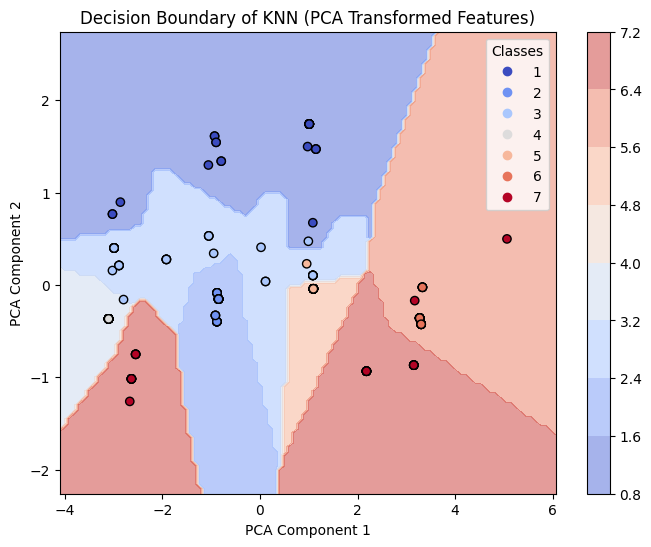

In [46]:
# Plot Decision Boundaries
plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, Z, alpha=0.5, cmap="coolwarm")  # Increased alpha for visibility
plt.colorbar(contour)  # Add colorbar to check class mapping
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_smote, cmap="coolwarm", edgecolor='k')

plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary of KNN (PCA Transformed Features)")
plt.show()

### **What are the key hyperparameters in KNN?**  
The key hyperparameters in **K-Nearest Neighbors (KNN)** are:  

#### **1. Number of Neighbors (`n_neighbors`)**  
- Determines how many nearest neighbors to consider for classification.  
- **Too small** (e.g., K=1) → High variance (overfitting).  
- **Too large** → High bias (underfitting).  

#### **2. Distance Metric (`metric`)**  
- Defines how distance is calculated between data points.  
- Common choices: **Euclidean, Manhattan, Minkowski, Hamming (for categorical data), Cosine**.  

#### **3. Weighting Scheme (`weights`)**  
- **`uniform`**: All neighbors have equal influence.  
- **`distance`**: Closer neighbors have more influence.  

#### **4. Power Parameter (`p`) for Minkowski Distance**  
- Used when `metric='minkowski'`.  
- **p=1  Manhattan Distance**  
- **p=2 Euclidean Distance**  

#### **5. Algorithm (`algorithm`)**  
- Controls how nearest neighbors are searched:  
  - **`brute`** (exhaustive search)  
  - **`kd_tree`** (faster for low-dimensional data)  
  - **`ball_tree`** (for larger datasets)  
  - **`auto`** (chooses best method automatically)  

---

### **What distance metrics can be used in KNN?**  
KNN uses **different distance metrics** depending on the type of data:  

#### **For Numerical Data**  
1. **Euclidean Distance** (`metric='euclidean'`)  
   - Most commonly used  
   - Computes straight-line distance between points  
   - \( d = \sqrt{\sum (x_i - y_i)^2} \)  

2. **Manhattan Distance** (`metric='manhattan'`)  
   - Measures distance along axes (grid-like movement)  
   - \( d = \sum |x_i - y_i| \)  

3. **Minkowski Distance** (`metric='minkowski'`)  
   - Generalized distance formula (power parameter `p`)  
   - \( d = \left( \sum |x_i - y_i|^p \right)^{1/p} \)  
   - When `p=1`, it's **Manhattan**; when `p=2`, it's **Euclidean**.  

4. **Chebyshev Distance** (`metric='chebyshev'`)  
   - Maximum absolute difference in any dimension  
   - \( d = \max(|x_i - y_i|) \)  

#### **For Categorical Data**  
5. **Hamming Distance** (`metric='hamming'`)  
   - Measures the number of different categorical values  
   - Used for **binary and categorical data**  

#### **For Text or High-Dimensional Data**  
6. **Cosine Similarity** (`metric='cosine'`)  
   - Measures the angle between two vectors  
   - Used for **text data (TF-IDF, embeddings, etc.)**  

7. **Jaccard Distance** (`metric='jaccard'`)  
   - Measures similarity between sets  
   - Used for **binary data or text-based data**  
